# OS5 Observing Scenario

This processes a time series of files produced by JPL integrated modeling pipeline. It is a time series of over-sampled dark hole datacubes, each of them corresponding to some amount of time (typically ~1000 seconds). 

In [8]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
from astropy.io import fits
import astropy.units as u
import sys
import os

os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST')
from params import Params
par = Params()

from crispy.tools.initLogger import getLogger
log = getLogger('crispy')


Populating the interactive namespace from numpy and matplotlib
params.py   params.pyc


## Initialize environment in which the computations will occur

In [9]:
lamc=770.      # central wavelength in nm
par.BW = 0.18  # ensure fractional bandwidth is right
par.nonoise=False # Turn this to True to turn all of the noise contributions off
sampling=2.0   # Number of lenslet per lambda/D, defined at lamc
par.timeframe=1000 # time corresponding to an individual datacube
toneframe = 100. # exposure time per frame
par.Nreads = par.timeframe/toneframe  # Number of reads that need to be done for each individual cube for a science target
par.PCmode=True  # Turn photon-counting mode on
par.EMStats=True # Turn Electron-multiplying statistics on
par.poisson=True # turn Poisson noise on
par.lifefraction = 0.0 # Run simulation at the beginning of life (this is not well handled for now)
par.lenslet_sampling=1./sampling 

# define where we will be operating
folder = '/Users/mrizzo/IFS/OS5_example_'+str(sampling)+'_t'+str(int(par.timeframe))
# define where the offaxis cube is
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
# define where the OS5 files are located
OS5_files = '/Users/mrizzo/IFS/OS5/with_lowfc/'

# construct folders
averagefolder = folder+'/average'
detectorfolder = folder+'/detector'

try:
    os.makedirs(folder)
except OSError:
    log.error("Couldn't create master folder - will overwrite")
    pass
try:
    os.makedirs(averagefolder)
except OSError:
    log.error("Couldn't create average folder - will overwrite")
    pass
try:
    os.makedirs(detectorfolder)  
except OSError:
    log.error("Couldn't create detector folder - will overwrite")
    pass


crispy - ERROR - Couldn't create master folder - will overwrite
crispy - ERROR - Couldn't create average folder - will overwrite
crispy - ERROR - Couldn't create detector folder - will overwrite


Syntax to run the main function is the following:

In [5]:
from crispy.tools.postprocessing import process_SPC_IFS2
signal, noise,noise_no_source,noise_no_rdi,signal_planet,signal_star,signal_no_rdi,signal_no_source = process_SPC_IFS2(par,
                    psf_time_series_folder=OS5_files,
                    offaxis_psf_filename=offaxis_psf_filename,
                    xshift=0.0,yshift=0.0,   # initial shift in the offaxis PSF
                    lamc=lamc,BW=par.BW,
                    n_ref_star_imgs=30, # the first 30 files correspond to the reference star
                    tel_pupil_area=3.65*u.m**2, # for the WFIRST pupil
                    IWA = 2.5,OWA = 9., # for the SPC mask
                    albedo_filename='Jupiter_1x_5AU_90deg.dat',
                    planet_radius = 1.27,
                    planet_AU = 3.6,planet_dist_pc=14.1,
                    albedo=0.25, # forcing albedo to be 25% at the peak of the function
                    target_star_T=5887*u.K, target_star_Vmag=5.03,   # representing 47 Uma
                    ref_star_T=9377*u.K, ref_star_Vmag=2.37, # representing Beta Uma
                    forced_inttime_ref = 10., # forced integration time for reference star individual frame
                    forced_tottime_ref = 1000., # forced integration time for reference star frame group
                    RDI=True, # do RDI
                    mflib='', # construct a matched filter library from scratch
                    outdir_time_series = folder,
                    outdir_detector=detectorfolder,
                    outdir_average=averagefolder,
                    process_cubes=False, # this only needs to be turned to True once
                    process_offaxis_files=True, # Construct planet and off-axis star files
                    process_detector=True, # Construct IFS detector maps
                    take_averages=True,   # Take averages of these detector maps
                    subtract_dark=True,
                    normalize_cubes=True,
                    nosource=False)


crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - X,Y Shift in px in original cubes: 0.00, 0.00
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_031.fits
crispy - INFO - Recentering off-axis cube
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_example_2.0_t1000/average/offaxiscube.fits
crispy - INFO - Constructing off-axis cube at planet separation: 4.44 lam/D (0.26 arcsec, 8.89 lenslets)
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_example_2.0_t1000/average/offaxiscube_shifted.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_example_2.0_t1000/average/offaxiscube_star_processed.fits
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - A

## Plot some of the results

In [8]:
ref_star = fits.getdata(folder+'/average'+'/average_ref_star_detector_red_optext_flatfielded.fits')
target_star_planet = fits.getdata(folder+'/average'+'/average_target_star_detector_red_optext_flatfielded.fits')
# target_star = fits.getdata(folder+'/average'+'/average_target_star_nosource_detector_red_optext_flatfielded.fits')
# planet = target_star_planet - target_star
planet = fits.getdata(folder+'/average'+'/offaxis_planet_red_optext_flatfielded.fits')
rdi_residual = fits.getdata(folder+'/average'+"/lstsq_residual.fits")
trim = 31


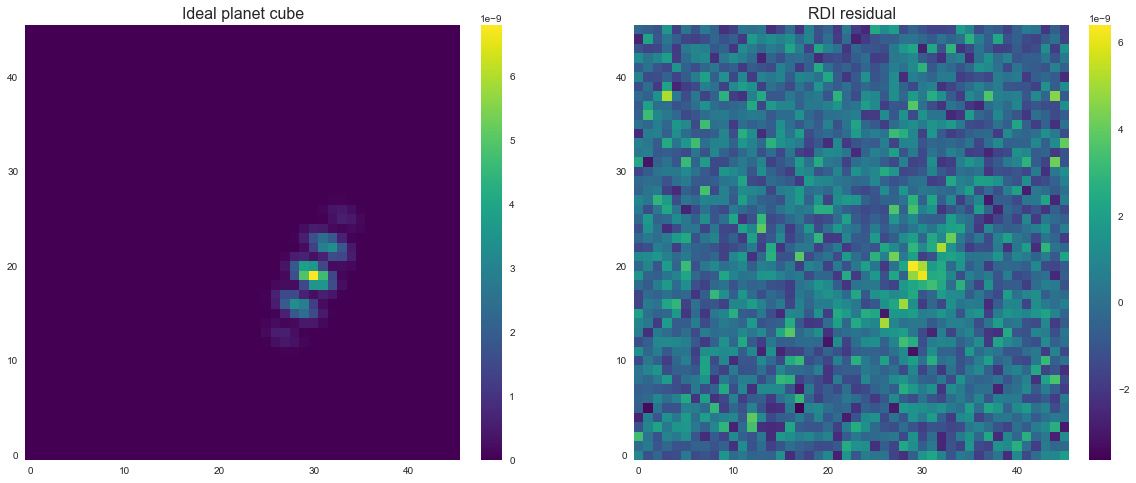

In [10]:
import ipywidgets
def plt_cubes_slices(wchan):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(planet[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Ideal planet cube",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.grid(False)
    plt.subplot(122)
    plt.imshow(rdi_residual[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("RDI residual",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.grid(False)
ipywidgets.interact(plt_cubes_slices, wchan=(1,planet.shape[0]));

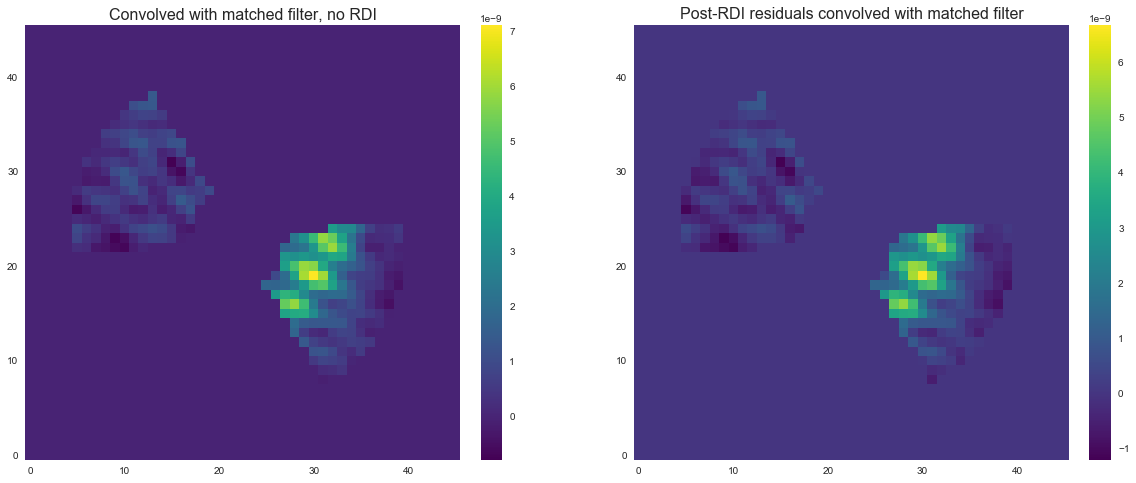

In [11]:
convolved_no_rdi_normalized = fits.getdata(folder+'/average'+'/convolved_no_rdi_normalized.fits')
convolved_normalized = fits.getdata(folder+'/average'+'/convolved_normalized.fits')


def plt_cubes_slices(wchan):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(convolved_no_rdi_normalized[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Convolved with matched filter, no RDI",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.grid(False)
    plt.subplot(122)
    plt.imshow(convolved_normalized[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.title("Post-RDI residuals convolved with matched filter",fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.grid(False)
ipywidgets.interact(plt_cubes_slices, wchan=(1,planet.shape[0]));

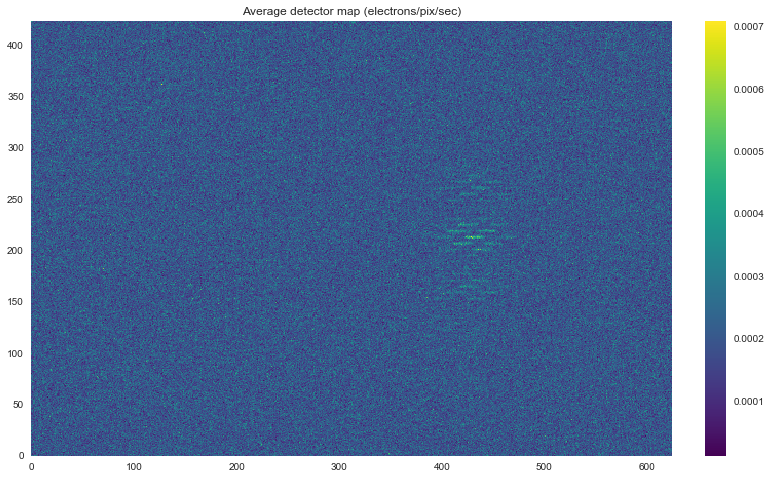

In [12]:
plt.figure(figsize=(15,8))
detector_map = fits.getdata(folder+'/average'+'/average_target_star_detector.fits')
plt.imshow(detector_map[300:-300,200:-200],cmap='viridis')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Average detector map (electrons/pix/sec)")
plt.grid(False)

However, runnin only one simulation doesn't yield the best results since the errors would be very hard to determine. In order to get good error bars, we can run a large number of these individual simulations in order to get relevant 1-sigma deviations.

## Multiple trials to build up good error bars

In order to obtain correct error bars, we invite the user to explore the following script:

crispy - INFO - iteration99
crispy - INFO - Reseeding random number generator
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - X,Y Shift in px in original cubes: 0.00, 0.00
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_031.fits
crispy - INFO - Recentering off-axis cube
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_example_2.0_t1000/average/offaxiscube.fits
crispy - INFO - Constructing off-axis cube at planet separation: 4.44 lam/D (0.26 arcsec, 8.89 lenslets)
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_example_2.0_t1000/average/offaxiscube_shifted.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_example_2.0_t1000/average/offaxiscube_star_processed.fits
crispy - INFO - The number of input pixels per lenslet is 5.0

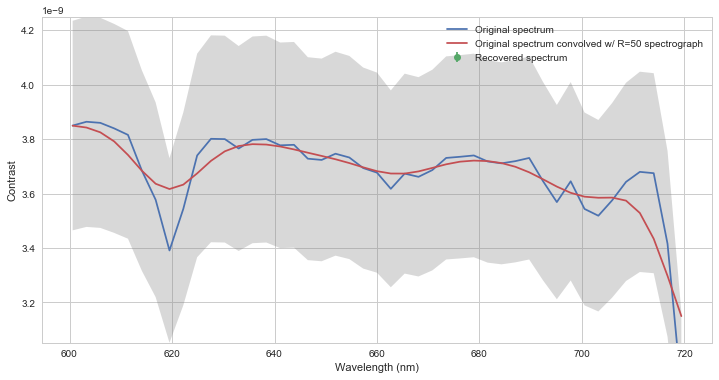

In [28]:
from IPython.display import clear_output
Ntrials=100
final_signal_cube = np.zeros((Ntrials,len(signal)))
final_signal_no_rdi_cube = np.zeros((Ntrials,len(signal)))
final_signal_star_cube = np.zeros((Ntrials,len(signal)))
final_signal_planet_cube = np.zeros((Ntrials,len(signal)))
final_signal = np.zeros(len(signal))
final_variance = np.zeros(len(signal))

import time
start = time.time()

for i in range(Ntrials):
    clear_output()
    log.info("iteration"+str(i))
    log.info("Reseeding random number generator")
    np.random.seed()
    signal, _,_,_,signal_planet,signal_star,signal_no_rdi,_ = process_SPC_IFS2(par,
                     psf_time_series_folder=OS5_files,
                    offaxis_psf_filename=offaxis_psf_filename,
                    xshift=0.0,yshift=0.0,   # initial shift in the offaxis PSF
                    lamc=lamc,BW=par.BW,
                    n_ref_star_imgs=30, # the first 30 files correspond to the reference star
                    tel_pupil_area=3.65*u.m**2, # for the WFIRST pupil
                    IWA = 2.5,OWA = 9., # for the SPC mask
                    albedo_filename='Jupiter_1x_5AU_90deg.dat',
                    planet_radius = 1.27,
                    planet_AU = 3.6,planet_dist_pc=14.1,
                    albedo=0.25, # forcing albedo to be 25% at the peak of the function
                    target_star_T=5887*u.K, target_star_Vmag=5.03,   # representing 47 Uma
                    ref_star_T=9377*u.K, ref_star_Vmag=2.37, # representing Beta Uma
                    forced_inttime_ref = 10., # forced integration time for reference star individual frame
                    forced_tottime_ref = 1000., # forced integration time for reference star frame group
                    RDI=True, # do RDI
                    mflib='', # construct a matched filter library from scratch
                    outdir_time_series = folder,
                    outdir_detector=detectorfolder,
                    outdir_average=averagefolder,
                    process_cubes=False, # this only needs to be turned to True once
                    process_offaxis_files=True, # Construct planet and off-axis star files
                    process_detector=True, # Construct IFS detector maps
                    take_averages=True,   # Take averages of these detector maps
                    subtract_dark=True,
                    normalize_cubes=True,
                    nosource=False)
    final_signal += signal
    final_variance += signal**2
    final_signal_cube[i] = signal
    final_signal_no_rdi_cube[i] = signal_no_rdi
    final_signal_star_cube[i] = signal_star
    final_signal_planet_cube[i] = signal_planet
final_signal /= Ntrials
final_variance /= Ntrials
final_variance -= final_signal**2
end = time.time()
print("Time elapsed: %f" % (end - start))
np.savetxt(averagefolder+"/final_signal_cube_"+str(par.timeframe)+".txt",final_signal_cube)
np.savetxt(averagefolder+"/final_signal_no_rdi_cube_"+str(par.timeframe)+".txt",final_signal_no_rdi_cube)
np.savetxt(averagefolder+"/final_signal_star_cube_"+str(par.timeframe)+".txt",final_signal_no_rdi_cube)
np.savetxt(averagefolder+"/final_signal_planet_cube_"+str(par.timeframe)+".txt",final_signal_no_rdi_cube)


plt.figure(figsize=(20,12))
ratio_out = SNR_spectrum(lam_midpts,final_signal,np.sqrt(final_variance),filename=par.codeRoot+"/Inputs/Jupiter_1x_5AU_90deg.dat",albedo=None,lam_contrast=wavelist,outfolder=par.exportDir+"/",
             FWHM=2*45./19.,FWHMdata=2,edges=1,ymargin=0.1,title='',planet_radius=1.27,planet_AU = 3.6)
plt.savefig(averagefolder+"/SNR_over_trials.png",dpi=300)


In [23]:
from scipy.interpolate import interp1d
from crispy.tools.reduction import calculateWaveList
from scipy import ndimage
from crispy.tools.inputScene import calc_contrast
import astropy.units as u
import astropy.constants as c
fontsize=25
# from scipy.interpolate import interp1d
folder = '/Users/mrizzo/IFS/OS5_SIM_2.0_t1000_770/average_47Umac_770/'
res = np.loadtxt(folder+'/final_signal_cube_1000.txt')
dat = np.mean(res,axis=0)
err = np.std(res,axis=0)

Nlam = 150
lams=lamc*np.linspace(1-par.BW/2.,1+par.BW/2.,Nlam)
par.wavecalDir = par.prefix+'/wavecalR50_770/'
lam_midpts660,junk = calculateWaveList(par,method='optext')
spectrum = np.loadtxt(par.codeRoot+"/Inputs/Jupiter_1x_5AU_90deg.dat")
spec_func = interp1d(spectrum[:,0]*1000.,spectrum[:,1])
vals = spec_func(lams)
vals /= np.amax(vals)
vals *= 0.25
vals = vals*(1.27*(c.R_jup).to(u.m)/(3.6*u.AU).to(u.m))**2
print vals

crispy - INFO - Reduced cube will have 19 wavelength bins
[  6.79519745e-09   6.46350224e-09   6.65415374e-09   6.77568227e-09
   6.75912160e-09   6.82901794e-09   6.87984748e-09   6.87058956e-09
   6.96369299e-09   6.98704988e-09   6.99316179e-09   7.04627981e-09
   7.05092082e-09   7.01923286e-09   7.04077544e-09   7.01897907e-09
   6.91045944e-09   6.63331785e-09   6.35147347e-09   5.85042313e-09
   5.51722664e-09   5.36614071e-09   5.15988424e-09   5.05775653e-09
   4.76408813e-09   4.41611400e-09   4.10447171e-09   3.92895792e-09
   3.89123099e-09   3.80277910e-09   4.24775495e-09   4.46653797e-09
   4.51769559e-09   5.07965497e-09   5.40484731e-09   5.75720427e-09
   5.96899932e-09   6.21680582e-09   5.93501921e-09   6.11176794e-09
   6.44634984e-09   6.66579703e-09   6.75767214e-09   6.89772804e-09
   7.02565418e-09   7.07409874e-09   7.09878462e-09   7.08725321e-09
   7.10070523e-09   7.10569428e-09   7.08893053e-09   7.08691122e-09
   7.07637038e-09   7.05657302e-09   7.061635

('Correction factor due to incorrect photon-counting compensation: ', <Quantity 0.9775171770913671>)


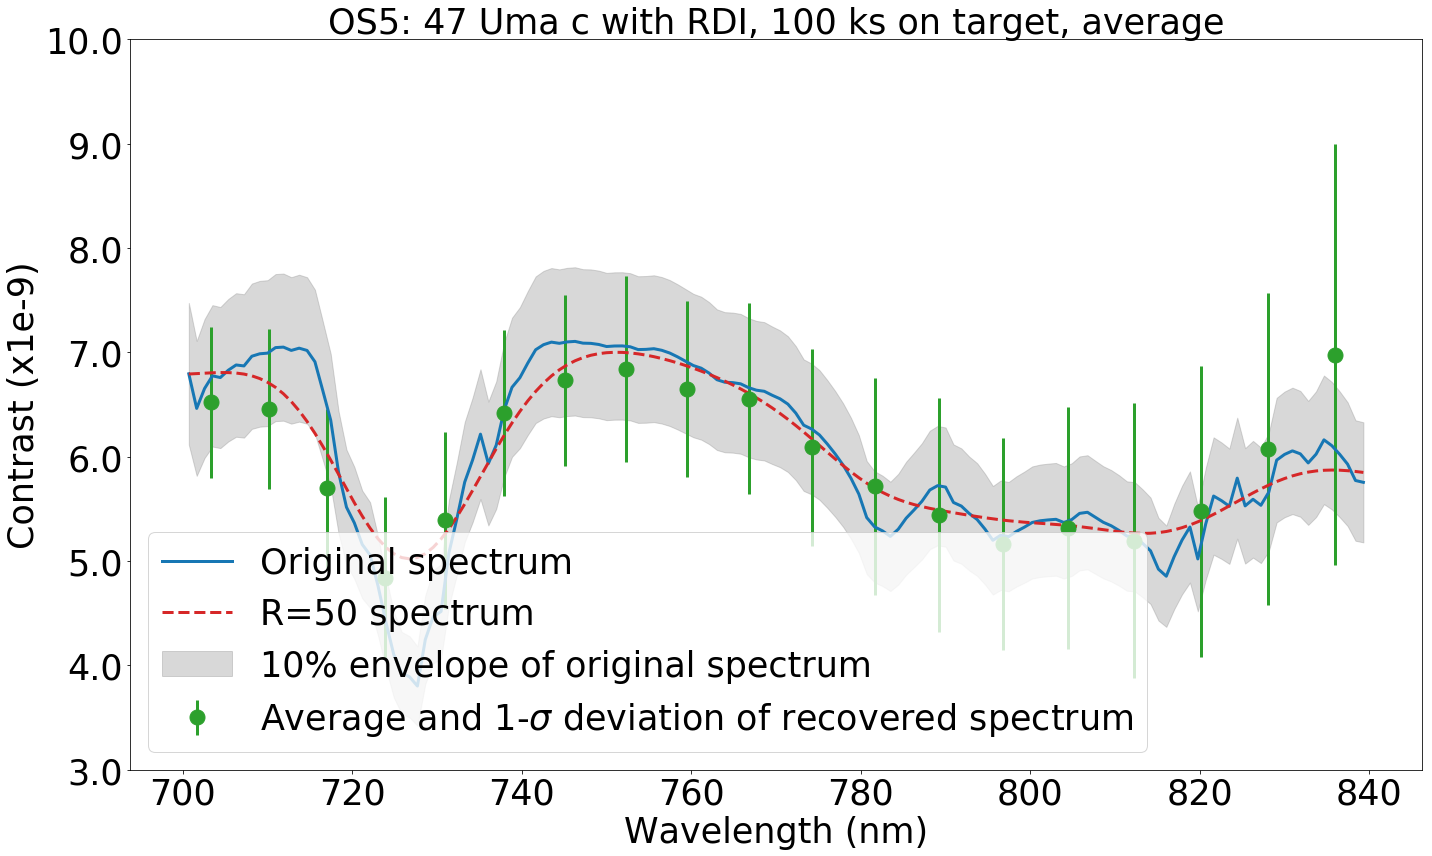

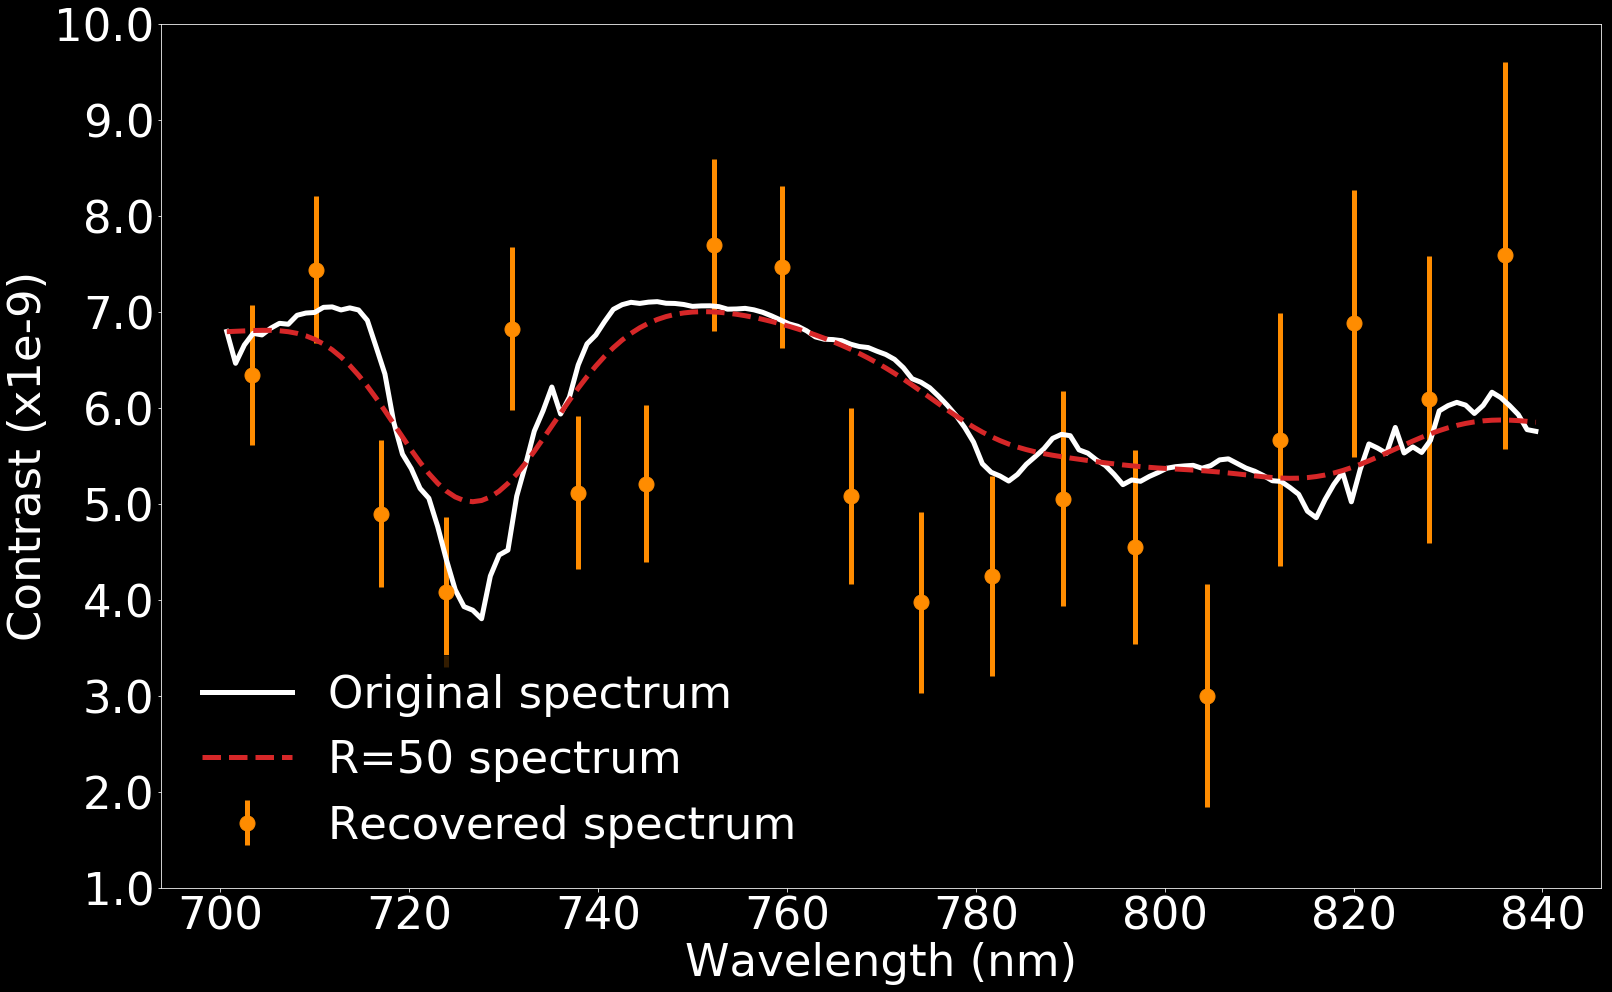

In [50]:
real_spectr660 = vals#calc_contrast(lams,distance=3.6, radius=1.27,filename=par.codeRoot+"/Inputs/Jupiter_1x_5AU_90deg.dat",albedo=0.25)
plt.figure(figsize=(20,12))
plt.plot(lams,real_spectr660,color='#1777b4',label='Original spectrum',lw=3)
smooth = ndimage.filters.gaussian_filter1d(real_spectr660,2.*Nlam/19./2.35,order=0,mode='nearest')

plt.fill_between(lams,0.9*real_spectr660,1.1*real_spectr660,color='Gray',alpha=0.3,label='10% envelope of original spectrum')
plt.plot(lams,smooth,label='R=50 spectrum',lw=3,color='#d62728',linestyle='--')

ratio660 = np.mean(real_spectr660)/np.mean(dat)
print("Correction factor due to incorrect photon-counting compensation: ",ratio660)
plt.errorbar(lam_midpts660,dat*ratio660,yerr=err*ratio660,fmt='o',markersize=15,elinewidth=3,color='#2ca02c',label='Average and 1-$\sigma$ deviation of recovered spectrum')
locs,labels = plt.yticks()
plt.yticks(locs, map(lambda x: "%.1f" % x, locs*1e9))
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.ylabel('Contrast (x1e-9)',fontsize=fontsize)
plt.xlabel('Wavelength (nm)',fontsize=fontsize)
plt.title('OS5: 47 Uma c with RDI, 100 ks on target, average',fontsize=35)
plt.legend(fontsize=fontsize,loc=3)
plt.tight_layout()
plt.savefig("/Users/mrizzo/Downloads/OS5_27hrs.png",dpi=200)

plt.figure(figsize=(20,12),facecolor='black', edgecolor='black')
ax = plt.axes((0., 0., 1.0, 1.0), axisbg='black')
ax.xaxis.set_tick_params(color='white', labelcolor='white')
ax.yaxis.set_tick_params(color='white', labelcolor='white')
for spine in ax.spines.values():
    spine.set_color('white')
fontsize=45
plt.plot(lams,real_spectr660,color='white',label='Original spectrum',lw=5)
#plt.fill_between(lams,0.9*real_spectr660,1.1*real_spectr660,color='white',alpha=0.5,label='10% envelope of original spectrum')
plt.plot(lams,smooth,label='R=50 spectrum',lw=5,color='#d62728',linestyle='--')
plt.errorbar(lam_midpts660,res[60]*ratio660,yerr=err*ratio660,fmt='o',markersize=15,elinewidth=5,color='darkorange',label='Recovered spectrum')
locs,labels = plt.yticks()
plt.yticks(locs, map(lambda x: "%.1f" % x, locs*1e9))
plt.tick_params(axis='both', which='major', labelsize=fontsize,color='white')
plt.ylabel('Contrast (x1e-9)',fontsize=fontsize,color='white')
plt.xlabel('Wavelength (nm)',fontsize=fontsize,color='white')
# plt.title('OS5: 47 Uma c with RDI, 100 ks on target, single trial',fontsize=35,color='white')
legend = plt.legend(fontsize=fontsize,loc=3)
frame = legend.get_frame()
frame.set_facecolor('black')
frame.set_edgecolor('black')
for text in legend.get_texts():
    text.set_color("white")
#plt.tight_layout()
plt.savefig("/Users/mrizzo/Downloads/OS5_27hrs_single_trial.png",dpi=200,facecolor='black')